In [1]:
#Load packages:
from IPython.display import display
%matplotlib inline
import json
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import itertools
import string
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Import Dataset

In [2]:
traindf = pd.read_json("train.json")
display(traindf.head(10))
print ("\n")
print ("Number recipies:", traindf.shape[0])

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."




Number recipies: 39774


### Explore Ingredients

In [3]:
# Make dictionary with single list of ingredients per cuisine and list of all ingredints
cuis_ingr = {}
ingr_list=[]
# Create dict with ket = cuisine and value = list of ingred.
for a,b in traindf.groupby('cuisine'):
    #done this way remos issue of list within list of ingr
    cuis_ingr[a] = list(itertools.chain.from_iterable(b['ingredients'].values))
    ingr_list+=list(itertools.chain.from_iterable(b['ingredients'].values))

In [4]:
# Count how many ingredients we have
print ('Totoal number of ingredients in dataset:', len(ingr_list))
               
# count how many single ingredients    
unique_ingr = pd.Series(ingr_list).value_counts()
print('number unique ingredients in dataset:',len(unique_ingr))
#Create list of unique ingredients
uniq_ingr_list = pd.Series(ingr_list).value_counts().index.tolist()


Totoal number of ingredients in dataset: 428275
number unique ingredients in dataset: 6714


In [5]:
# Number of ingredients that appear only once in the dataset
print("ingredients that appear only once:", len(unique_ingr[unique_ingr==1]))

ingredients that appear only once: 1759


In [6]:
print("most commonly used ingredients and how many times they appear:")
unique_ingr[:10]

most commonly used ingredients and how many times they appear:


salt                   18049
onions                  7972
olive oil               7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
dtype: int64

#### Add column with number of ingredients per recipe

In [7]:
traindf['tot_ingr']=[len(rec) for rec in traindf['ingredients']]

In [8]:
traindf.ix[:3,]

,cuisine,id,ingredients,tot_ingr
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]",4


## Calculate stats about ingredients per recipe

In [9]:
# avg num ingredient per cuisine
ingr_avg=traindf['tot_ingr'].groupby(traindf['cuisine']).mean().tolist()
# stdev num ingredient per cuisine
ingr_std=traindf['tot_ingr'].groupby(traindf['cuisine']).std().tolist()
cuis_list=traindf['tot_ingr'].groupby(traindf['cuisine']).mean().index.tolist()

### Plot Stats

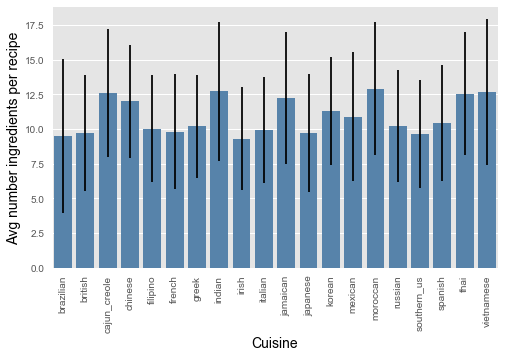

In [10]:
ingr_plot = sns.barplot(x = cuis_list, y = ingr_avg, yerr=ingr_std, color="#4984b8")
plt.subplots_adjust(bottom=0.22)
ingr_plot.set_ylabel("Avg number ingredients per recipe",size = 14,color="black")
ingr_plot.set_xlabel("Cuisine", size=14, color='black')
for item in ingr_plot.get_xticklabels():
    item.set_rotation(90)
ingr_plot.figure.savefig('avg_ingr.png')

## Total recipes per cuisine:

In [11]:
cuisines = traindf['cuisine'].value_counts()
cuisines_perc = traindf['cuisine'].value_counts()/sum(cuisines)
tot_rec = sum(cuisines)
print(cuisines_perc)

italian         0.197063
mexican         0.161865
southern_us     0.108614
indian          0.075502
chinese         0.067205
french          0.066526
cajun_creole    0.038870
thai            0.038694
japanese        0.035777
greek           0.029542
spanish         0.024865
korean          0.020868
vietnamese      0.020742
moroccan        0.020642
british         0.020214
filipino        0.018982
irish           0.016770
jamaican        0.013225
russian         0.012294
brazilian       0.011741
Name: cuisine, dtype: float64


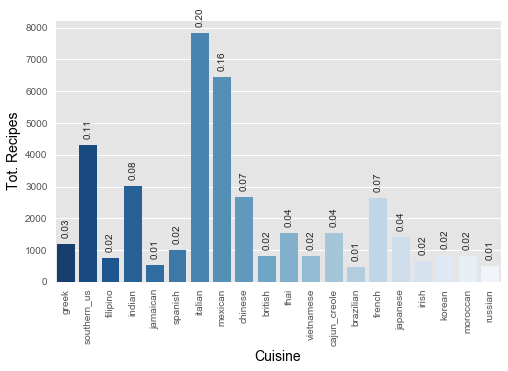

In [12]:
cuis_plot = sns.countplot(x = 'cuisine', data=traindf, palette="Blues_r") 
plt.subplots_adjust(bottom=0.22)
cuis_plot.set_ylabel('Tot. Recipes',size = 14,color="black")
cuis_plot.set_xlabel('Cuisine',size = 14,color="black")
for item in cuis_plot.get_xticklabels():
    item.set_rotation(90)
for p in cuis_plot.patches:
    height = p.get_height()
    cuis_plot.text(p.get_x()+p.get_width()/2.,
            height+500,
            '{:1.2f}'.format(height/tot_rec),
            ha="center", va='center',rotation=90)
cuis_plot.figure.savefig('recipe_cuisine.png')

## 10 most common ingredients per cuisine:

In [13]:
top_ingr={}
for key, val in cuis_ingr.items():
    top_ingr[key]=pd.Series(val).value_counts().index.tolist()[:10]

In [14]:
top10x20= pd.Series(list(itertools.chain.from_iterable(top_ingr.values())))

In [15]:
top10x20_list=top10x20.value_counts().index.tolist()
top10x20_val=top10x20.value_counts()

In [16]:
top10x20_val[:10]

salt                 20
water                16
onions               13
garlic               12
sugar                12
garlic cloves         9
olive oil             8
butter                7
soy sauce             6
all-purpose flour     6
dtype: int64

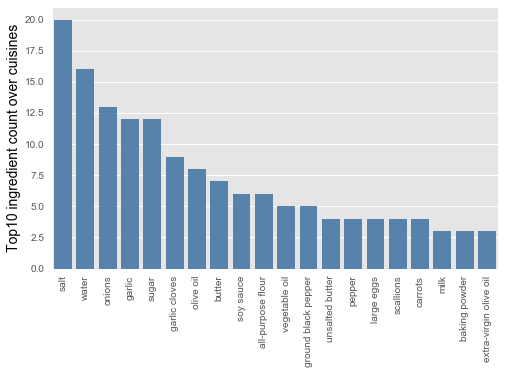

In [17]:
top10_plot = sns.barplot(x = top10x20_list[:20], y = top10x20_val[:20], color="#4984b8")
plt.subplots_adjust(bottom=0.22)
top10_plot.set_ylabel("Top10 ingredient count over cuisines",size = 14,color="black")
for item in top10_plot.get_xticklabels():
    item.set_rotation(90)

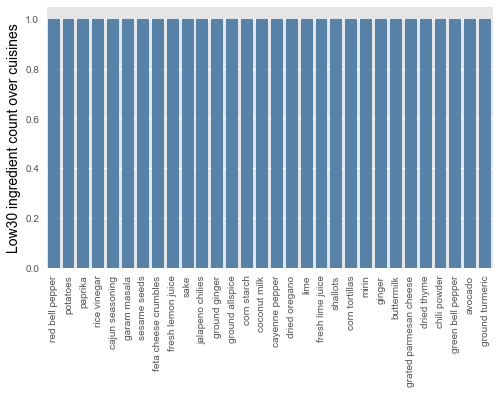

In [18]:
top10_plot = sns.barplot(x = top10x20_list[-30:], y = top10x20_val[-30:], color="#4984b8")
plt.subplots_adjust(bottom=0.22)
top10_plot.set_ylabel("Low30 ingredient count over cuisines",size = 14,color="black")
for item in top10_plot.get_xticklabels():
    item.set_rotation(90)

## Table that compare top 10 ingredients for each cuisine:

In [19]:
top_ingr_df = pd.DataFrame.from_dict(top_ingr, orient='index')
top_ingr_df

,0,1,2,3,4,5,6,7,8,9
brazilian,salt,onions,olive oil,lime,water,garlic cloves,garlic,cachaca,sugar,tomatoes
british,salt,all-purpose flour,butter,milk,eggs,unsalted butter,sugar,onions,baking powder,large eggs
cajun_creole,salt,onions,garlic,green bell pepper,butter,olive oil,cayenne pepper,cajun seasoning,all-purpose flour,water
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
filipino,salt,garlic,water,onions,soy sauce,pepper,oil,sugar,carrots,ground black pepper
french,salt,sugar,all-purpose flour,unsalted butter,olive oil,butter,water,large eggs,garlic cloves,ground black pepper
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles,extra-virgin olive oil,fresh lemon juice,ground black pepper,garlic,pepper
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
irish,salt,butter,all-purpose flour,onions,sugar,potatoes,baking soda,baking powder,milk,carrots
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter


## Searching for issues in the ingredients list:

In [20]:
# Contains special characters
punct_ingr = set()
multi_word_ingr = set()
brands_ingr = set()

for i in uniq_ingr_list:
    # multi-word ingredients
    if len(i.split()) != 1:
        multi_word_ingr.add(i)
    # ingrdients with punctuation in it
    for letter in i:
        if letter in string.punctuation:
            punct_ingr.add(i)
    # brand names through unicode special chars        
    if u'\u00AE' in i or u'\u2122' in i:
        brands_ingr.add(i)
            

In [21]:
print('Unique ingredients: %d' % len(uniq_ingr_list))
print('Ingredients with brand names in it: %d' % len(brands_ingr))
print('Ingredients with multiple words in it: %d' % len(multi_word_ingr))
print('Ingredients with punctuation in it: %d' % len(punct_ingr))

Unique ingredients: 6714
Ingredients with brand names in it: 69
Ingredients with multiple words in it: 5539
Ingredients with punctuation in it: 363


### Print out a few of the ingredients with the characteristics we looked for

In [22]:
print(list(brands_ingr)[:10])
print('\n')
print(list(multi_word_ingr)[:10])
print('\n')
print(list(punct_ingr)[:10])

['Hidden Valley® Original Ranch® Light Dressing', "I Can't Believe It's Not Butter!® All Purpose Sticks", "Old El Paso™ Thick 'n Chunky salsa", 'Ragu® Robusto!® Pasta Sauce', 'Country Crock® Spread', 'BACARDI® Mixers Margarita Mix', 'Truvía® Baking Blend', 'Mazola® Chicken Flavor Bouillon Powder', 'Best Foods® Real Mayonnaise', 'Bertolli® Classico Olive Oil']


['sweet pickle', 'seedless raspberry jam', 'cooked ham', 'cod fillets', 'Fuji Apple', 'fresh prawn', 'tropical fruits', 'low fat coleslaw dressing', 'sweet and sour sauce', 'smooth natural peanut butter']


['parmigiano-reggiano cheese', 'ogura-an', 'low-fat cheese', 'chocolate-hazelnut spread', '(14.5 oz.) diced tomatoes', 'bread, cut french into loaf', 'freeze-dried strawberries', "Hellmann's Dijonnaise Creamy Dijon Mustard", 'soft-shell clams', 'Flora pro.activ']
